<img src="https://cdn.siberian.dev/siberian.png" alt="Siberian Logo">

### License Plate Detection Using OpenCV Using Python

This Code Template is for Car Plate Number Detection using OpenCV in Python. It takes a video as input and outputs the car plate number with a boundary/box surrounding it per frame in the video. This template uses EasyOCR to convert text on an image to a string. 

### **Required Packages**

In [ ]:
!pip install easyocr
!pip install imutils
!pip install opencv-contrib-python --upgrade

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr
import warnings
warnings.filterwarnings("ignore")

### Initialization

Path of the video to be loaded

In [2]:
#video path variable
vid_path = ''

### Convert image/video frame into gray_scale

In [3]:
def gray_scale(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    return gray

### Apply filter and then find edges
This function first applies <Code>bilateralFilter</Code> to filter the image and hence, reduce noise, then applies <Code>Canny</Code> to find edges using the Canny algorithm

#### bilateralFilter Parameters [API](https://docs.opencv.org/master/d4/d86/group__imgproc__filter.html#ga9d7064d478c95d60003cf839430737ed):

1. src:	
>Source 8-bit or floating-point, 1-channel or 3-channel image.
2. d:
>Diameter of each pixel neighborhood that is used during filtering. If it is non-positive, it is computed from sigmaSpace.
3. sigmaColor:
>Filter sigma in the color space. A larger value of the parameter means that farther colors within the pixel neighborhood (see sigmaSpace) will be mixed together, resulting in larger areas of semi-equal color.
4. sigmaSpace:
>Filter sigma in the coordinate space. A larger value of the parameter means that farther pixels will influence each other as long as their colors are close enough (see sigmaColor ). When d>0, it specifies the neighborhood size regardless of sigmaSpace. Otherwise, d is proportional to sigmaSpace.

#### Canny Parameters [API](https://docs.opencv.org/master/dd/d1a/group__imgproc__feature.html#ga04723e007ed888ddf11d9ba04e2232de):
1. image:	
>8-bit input image.
2. threshold1:	
>first threshold for the hysteresis procedure.
3. threshold2:	
>second threshold for the hysteresis procedure.

In [4]:
def filter_img(img):
    img = cv2.bilateralFilter(src = img, 
                              d = 5, 
                              sigmaColor = 15, 
                              sigmaSpace = 15) 
    edged = cv2.Canny(image = img, 
                      threshold1 = 30, 
                      threshold2 = 200) 
    
    return edged

### Apply Mask
This function first find contours and then apply mask to isolate the car number plate
#### findContours Parameters:
1. mode	
>Contour retrieval mode, see [RetrievalModes](https://docs.opencv.org/master/d3/dc0/group__imgproc__shape.html#ga819779b9857cc2f8601e6526a3a5bc71)
2. method	
>Contour approximation method, see [ContourApproximationModes](https://docs.opencv.org/master/d3/dc0/group__imgproc__shape.html#ga4303f45752694956374734a03c54d5ff)
3. offset	
>Optional offset by which every contour point is shifted. This is useful if the contours are extracted from the image ROI and then they should be analyzed in the whole image context.

In [5]:
def apply_mask(edged_img, 
               gray_img,
               img,
               mode = cv2.RETR_TREE,
               method = cv2.CHAIN_APPROX_TC89_L1):
    keypoints = cv2.findContours(image = edged_img, 
                                 mode = mode, 
                                 method = method)
    contours = imutils.grab_contours(keypoints)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
    
    location = None
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 10, True)
        if len(approx) == 4:
            location = approx
            break
            
    mask = np.zeros(gray_img.shape, np.uint8)
    if type(location) != type(None):
        cv2.drawContours(mask, [location], 0,255, -1)
        cv2.bitwise_and(img, img, mask=mask)
        (x,y) = np.where(mask==255)
        (x1, y1) = (np.min(x), np.min(y))
        (x2, y2) = (np.max(x), np.max(y))
        cropped_image = gray_img[x1:x2+1, y1:y2+1]
    else:
        return None
    
    return cropped_image, approx

### Call EasyOCR to read text
The following user-defined function takes an image comprising some text and the list of languages in which the text may have been written in, calls EasyOCR's <Code>Reader</Code> class and thens return the text as string

EasyOCR uses Pytorch at the backend

[List of supported languages](https://www.jaided.ai/easyocr/)

In [6]:
def read_text(cropped_image, language = ['en']):
    reader = easyocr.Reader(language)
    return reader.readtext(cropped_image)

### Draw text on the video frame

In [7]:
def draw_on_frame(result, img, approx):
    text = result[0][-2]
    font = cv2.FONT_HERSHEY_SIMPLEX
    res = cv2.putText(img, 
                          text=text, 
                          org=(approx[0][0][0], 
                               approx[1][0][1]+60), 
                          fontFace=font, 
                          fontScale=1, 
                          color=(0,255,0), 
                          thickness=2, 
                          lineType=cv2.LINE_AA)


    res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3)


    return res

### Combing Functions and detecting Car Number Plate per video frame

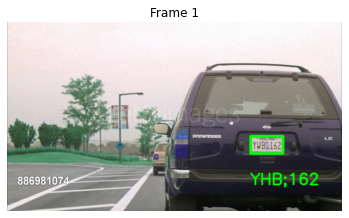

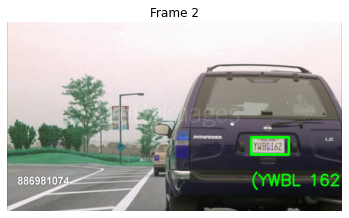

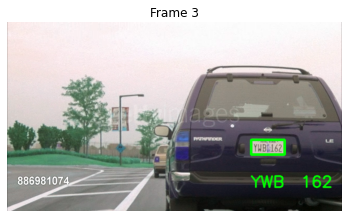

In [8]:
cap = cv2.VideoCapture(vid_path)
count = 0
while count<3:
        _,img = cap.read()
        gray = gray_scale(img)
        edged = filter_img(gray)
        cropped_image, approx = apply_mask(edged.copy(), gray, img)
        result = read_text(cropped_image)
        try:
            count = count+1
            res = draw_on_frame(result, img, approx)
            plt.imshow(res)
            plt.axis("off")
            plt.title(f"Frame {count}")
            plt.pause(1)
        except:
            pass  

#### Creator: Viraj Jayant, Github: [Profile](https://github.com/Viraj-Jayant)